In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import lightgbm as lgb

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
### READ DATA ###

df = pd.read_csv('day.csv')
df['dteday'] = pd.to_datetime(df.dteday)

print(df.shape)
df.head()

(731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
### CASUAL COUNT STATISTICS ###

df.groupby('yr')['casual'].agg(['min','max','mean'])

,min,max,mean
yr,,,
0,9,3065,677.402740
1,2,3410,1018.483607


In [4]:
### DEFINE CRPS METRIC ###

def crps(y_true, y_pred):
    y_true = np.clip(np.cumsum(y_true, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    return ((y_true-y_pred)**2).sum(axis=1).sum(axis=0) / (y_true.shape[1]*y_true.shape[0])

In [5]:
### DEFINE REGRESSOR COLUMNS ###

columns = [c for c in df.columns if c not in ['instant','dteday','casual','registered','cnt']]
print(columns)

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


In [6]:
### TRAIN, VALIDATION, TEST SPLIT ###

X_train = df[df.dteday < datetime(year=2012, month=1, day=1)].copy()
train_date = X_train.dteday.values

X_val = df[(df.dteday >= datetime(year=2012, month=1, day=1))&(df.dteday < datetime(year=2012, month=5, day=1))].copy()
val_date = X_val.dteday.values

X_test = df[(df.dteday >= datetime(year=2012, month=5, day=1))].copy()
test_date = X_test.dteday.values

print(X_train.shape, X_val.shape, X_test.shape)
X_train.head()

(365, 16) (121, 16) (245, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


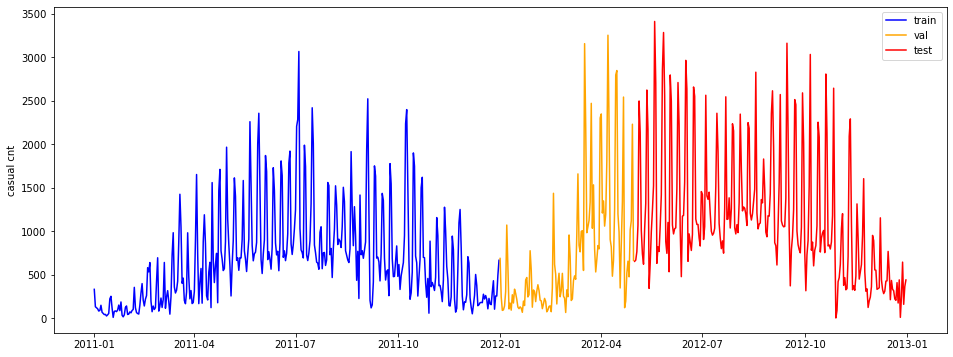

In [7]:
### CASUAL COUNT PLOT ###

plt.figure(figsize=(16,6))

plt.plot(train_date, X_train.casual, label='train', color='blue')
plt.plot(val_date, X_val.casual, label='val', color='orange')
plt.plot(test_date, X_test.casual, label='test', color='red')
plt.ylabel('casual cnt')
plt.legend()

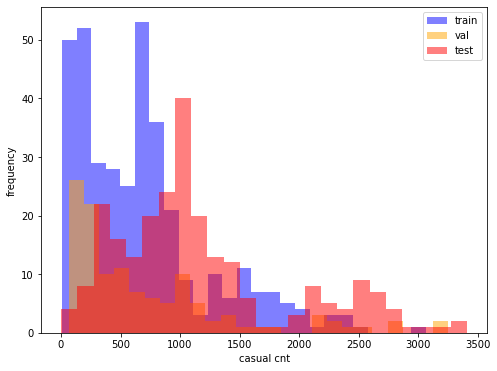

In [8]:
### CASUAL COUNT DISTRIBUTION ###

plt.figure(figsize=(8,6))

plt.hist(X_train.casual, label='train', bins=25, alpha=0.5, color='blue')
plt.hist(X_val.casual, label='val', bins=25, alpha=0.5, color='orange')
plt.hist(X_test.casual, label='test', bins=25, alpha=0.5, color='red')
plt.ylabel('frequency'); plt.xlabel('casual cnt')
plt.legend()

In [9]:
### DEFINE MAX PLAUSIBLE CASUAL COUNT ###
max_count = 4000

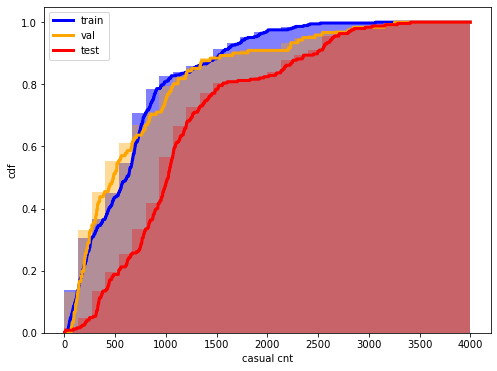

In [10]:
### CDF CASUAL COUNT PLOT ###

plt.figure(figsize=(8,6))

plt.hist(X_train.casual, range=(0,max_count), bins=30, 
         cumulative=True, density=True, alpha=0.5, color='blue')
cdf = np.histogram(X_train.casual, range=(0,max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf, c='blue', linewidth=3, label='train')

plt.hist(X_val.casual, range=(0,max_count), bins=30, 
         cumulative=True, density=True, alpha=0.4, color='orange')
cdf = np.histogram(X_val.casual, range=(0,max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf, c='orange', linewidth=3, label='val')

plt.hist(X_test.casual, range=(0,max_count), bins=30, 
         cumulative=True, density=True, alpha=0.3, color='red')
cdf = np.histogram(X_test.casual, range=(0,max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf, c='red', linewidth=3, label='test')

plt.ylabel('cdf'); plt.xlabel('casual cnt')
plt.legend()

# SURVIVAL LGBM 

In [11]:
### EXPAND TRAIN DATA ###

X_train['count_so_far'] = X_train.apply(lambda x: np.arange(x.casual), axis=1)
X_train['stop'] = X_train.apply(lambda x: np.append(np.zeros(x.casual-1), 1), axis=1)
X_train = X_train.apply(pd.Series.explode)

X_train['count_so_far'] = X_train.count_so_far.astype(int)
X_train['stop'] = X_train.stop.astype(int)

y_train = X_train['stop']
X_train = X_train[columns+['count_so_far']]

print(X_train.shape)

(247252, 12)


In [12]:
### EXPAND VALID DATA ###

X_val['count_so_far'] = X_val.apply(lambda x: np.arange(x.casual), axis=1)
X_val['stop'] = X_val.apply(lambda x: np.append(np.zeros(x.casual-1), 1), axis=1)
X_val = X_val.apply(pd.Series.explode)

X_val['count_so_far'] = X_val.count_so_far.astype(int)
X_val['stop'] = X_val.stop.astype(int)

y_val = X_val['stop']
X_val = X_val[columns+['count_so_far']]

print(X_val.shape)

(87764, 12)


In [13]:
### EXPAND VALID DATA FOR PREDICTION ###

X_val_surv = df[(df.dteday >= datetime(year=2012, month=1, day=1))&(df.dteday < datetime(year=2012, month=5, day=1))].copy()

X_val_surv['count_so_far'] = X_val_surv.apply(lambda x: np.arange(max_count), axis=1)
X_val_surv['stop'] = X_val_surv.apply(lambda x:np.append(np.zeros(x.casual), np.ones(max_count-x.casual)), axis=1)
X_val_surv = X_val_surv.apply(pd.Series.explode)

X_val_surv['count_so_far'] = X_val_surv.count_so_far.astype(int)
X_val_surv['stop'] = X_val_surv.stop.astype(int)

y_val_surv = X_val_surv['stop']
X_val_surv = X_val_surv[columns+['count_so_far']]

print(X_val_surv.shape)

(484000, 12)


In [14]:
### EXPAND TEST DATA ###

X_test['count_so_far'] = X_test.apply(lambda x: np.arange(x.casual), axis=1)
X_test['stop'] = X_test.apply(lambda x: np.append(np.zeros(x.casual-1), 1), axis=1)
X_test = X_test.apply(pd.Series.explode)

X_test['count_so_far'] = X_test.count_so_far.astype(int)
X_test['stop'] = X_test.stop.astype(int)

y_test = X_test['stop']
X_test = X_test[columns+['count_so_far']]

print(X_test.shape)

(285001, 12)


In [15]:
### EXPAND TEST DATA FOR PREDICTION ###

X_test_surv = df[(df.dteday >= datetime(year=2012, month=5, day=1))].copy()

X_test_surv['count_so_far'] = X_test_surv.apply(lambda x: np.arange(max_count), axis=1)
X_test_surv['stop'] = X_test_surv.apply(lambda x: np.append(np.zeros(x.casual), np.ones(max_count-x.casual)), axis=1)
X_test_surv = X_test_surv.apply(pd.Series.explode)

X_test_surv['count_so_far'] = X_test_surv.count_so_far.astype(int)
X_test_surv['stop'] = X_test_surv.stop.astype(int)

y_test_surv = X_test_surv['stop']
X_test_surv = X_test_surv[columns+['count_so_far']]

print(X_test_surv.shape)

(980000, 12)


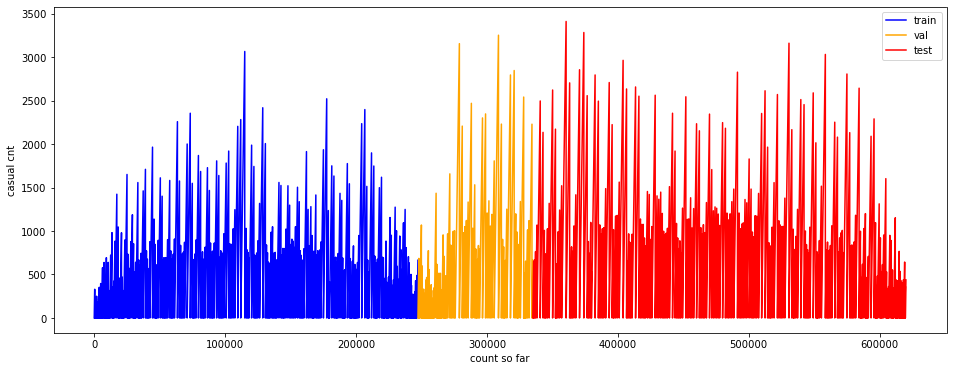

In [16]:
### PLOT COUNT SO FAR VARIABLE ### 

plt.figure(figsize=(16,6))

plt.plot(range(len(X_train)), X_train.count_so_far, label='train', color='blue')
plt.plot(range(len(X_train),len(X_val)+len(X_train)), X_val.count_so_far, label='val', color='orange')
plt.plot(range(len(X_val)+len(X_train),len(X_val)+len(X_train)+len(X_test)), X_test.count_so_far, label='test', color='red')
plt.ylabel('casual cnt'); plt.xlabel('count so far')
plt.legend(loc='upper right')

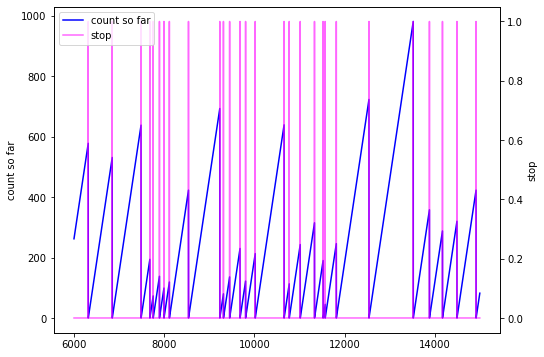

In [17]:
### PLOT COUNT SO FAR VARIABLE ZOOM ### 

plt.figure(figsize=(8,6))

csf = plt.plot(range(6000,15000), X_train.count_so_far[6000:15000], color='blue')
plt.ylabel('count so far')
plt.twinx()
scr = plt.plot(range(6000,15000), y_train[6000:15000], color='magenta', alpha=0.6)
plt.ylabel('stop')
plt.legend(csf+scr, ['count so far', 'stop'], loc='upper left')

In [18]:
params = {
         'objective':'poisson',
         'num_leaves':30, 
         'learning_rate': 0.001,
         'feature_fraction': 0.8,
         'bagging_fraction': 0.9,
         'bagging_seed': 33,
         'poisson_max_delta_step': 0.8,
         'metric': 'poisson'
         }

In [19]:
### FIT LGBM WITH POISSON LOSS ### 

trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, trn_data, num_boost_round=1000,
                  valid_sets = [trn_data, val_data],
                  verbose_eval=50, early_stopping_rounds=150)

Training until validation scores don't improve for 150 rounds.
[50]	training's poisson: 0.0109487	valid_1's poisson: 0.0103453
[100]	training's poisson: 0.0108272	valid_1's poisson: 0.010255
[150]	training's poisson: 0.0107241	valid_1's poisson: 0.0102008
[200]	training's poisson: 0.0106252	valid_1's poisson: 0.0101618
[250]	training's poisson: 0.0105319	valid_1's poisson: 0.0101535
[300]	training's poisson: 0.010446	valid_1's poisson: 0.0101581
[350]	training's poisson: 0.0103616	valid_1's poisson: 0.0101667
Early stopping, best iteration is:
[247]	training's poisson: 0.0105386	valid_1's poisson: 0.0101518


In [20]:
### PREDICT HAZARD FUNCTION ON VALIDATION DATA AND TRANSFORM TO SURVIVAL ###

p_val_hz = model.predict(X_val_surv).reshape(-1,max_count)
p_val = 1-np.exp(-np.cumsum(p_val_hz, axis=1))
p_val.shape

(121, 4000)

In [21]:
### GET TRUE CDF ON VALIDATION DATA ###

t_val = y_val_surv.values.reshape(-1,max_count)
t_val.shape

(121, 4000)

In [22]:
### CRPS ON VALIDATION DATA ###

crps(t_val, p_val)

0.17432894983162234

In [23]:
### CRPS ON VALIDATION DATA WITH BASELINE MODEL ###

crps(t_val, np.repeat(cdf, len(t_val)).reshape(-1,max_count))

0.17963328860908506

In [24]:
### PREDICT HAZARD FUNCTION ON TEST DATA AND TRANSFORM TO SURVIVAL ###

p_test_hz = model.predict(X_test_surv).reshape(-1,max_count)
p_test = 1-np.exp(-np.cumsum(p_test_hz, axis=1))
p_test.shape

(245, 4000)

In [25]:
### GET TRUE CDF ON TEST DATA ###

t_test = y_test_surv.values.reshape(-1,max_count)
t_test.shape

(245, 4000)

In [26]:
### CRPS ON TEST DATA ###

crps(t_test, p_test)

0.28359956405330844

In [27]:
### CRPS ON TEST DATA WITH BASELINE MODEL ###

crps(t_test, np.repeat(cdf, len(t_test)).reshape(-1,max_count))

0.2892390593715204

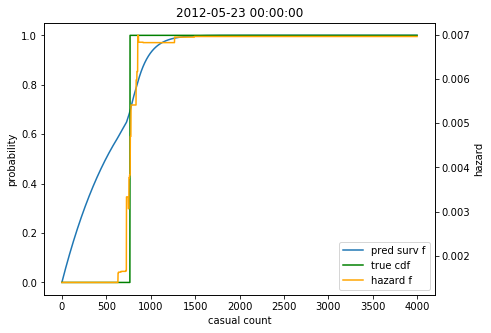

In [28]:
### PLOT PREDICTIONS ###
_id = 22

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.ylabel('probability'); plt.xlabel('casual count')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.title(pd.to_datetime(test_date[_id]))
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')